In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))
from rest.utils import *

import numpy as np
import casadi as ca

### **Problem setup:**

- Task: start from given initial position $p_0$, to reach a given terget position $p_T$ (Stabilization)

- Slope profile (height $h$ with reference to horizontal displacement $p$):  
   - case 1: zero slope (linear case), $h(p) = c$
   - case 2: constant slope (linear case), $h(p) = k \cdot p$
   - case 3: varying slope (nonlinear case), $h(p) = k \cdot cos(\omega p)$
   - case 4: varying slope for under actuated case (nonlinear case), $h(p) = k \cdot sin(\omega p)$

- System dynmaics of 1d mountain car model (in State space representation): 
   - state vector $\bm{x} = [p, v]^T$
   - input vector $u = a$
   - system dynamics:
   \begin{align*}
     \begin{bmatrix} \dot{p} \\ \dot{v} \end{bmatrix} = \begin{bmatrix} v \\ - g \sin(\theta) \cos(\theta) \end{bmatrix} + \begin{bmatrix} 0 \\ \cos(\theta)  \end{bmatrix} a
   \end{align*}

---

### **Part (a): define the mountain car environment and the system dynamics**

In the previous exercise, we demonstrated how to define a symbolic function using CasADi symbolic system, inclusive defining the profile over a slope $h(p)$, deriving the conversion formulas between the slope profile $h(p)$ and the inclination angle $\theta(p)$, and establish the system's dynamics. These formulas have already been integrated into the class `Env` and `Dynamics`. In this chapter, we will specify the arguments and instantiate these classes directly to utilize their functionalities.

**Step 1: specify the arguments for class `Env` and instantiate the class**

- To start with the simpler case (also more compatible with LQR), we will initially focus on a linear system in an unconstrained scenario

- Parameters in the task:  
   - case: 1 / 2 / 3 / 4
   
   - initial state: $\bm{x}_0 = [-1.2, 0.0]^T$
   - target state: $\bm{x}_T = [0.6, 0.0]^T$

**Step 2: call function `test_env()` to plot the mountain profile $h(p)$ and curve of inclination angle $\theta(p)$**

**Step 3: specify the arguments for class `Dynmaics` and instantiate the class**



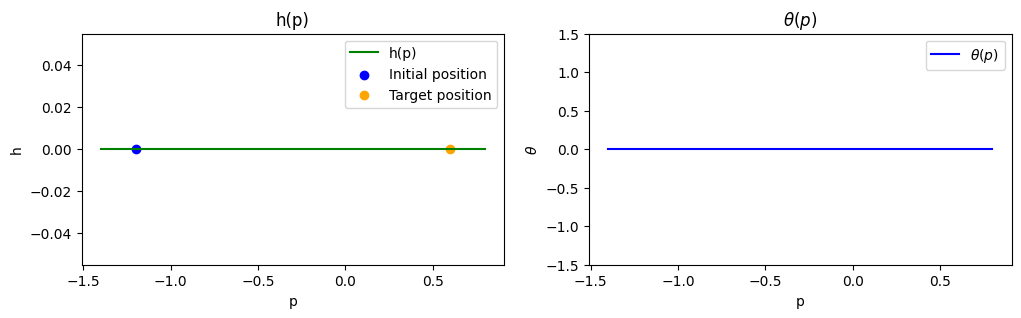

In [2]:
# Define profile of slope, the initial / target state
case = 1 # 1 or 2 or 3 or 4
initial_position = -1.2
initial_velocity = 0.0
target_position = 0.6
target_velocity = 0.0

# Instantiate class 'Env'
# Arguments (without constraints): 
#   1) case: $n \in [1, 2, 3, 4]$, type: int
#   2) initial state: x_0 = [p_0, v_0], type: np.array
#   3) terminal state: x_T = [p_T, v_T], type: np.array
env = Env(case, np.array([initial_position, initial_velocity]), np.array([target_position, target_velocity]))
env.test_env() #  shape of slope (left side) and theta curve (right side) 

# Instantiate class 'Dynamics'
# Arguments: 
#   1) an object of class `Env`, type: Env  
dynamics = Dynamics(env)

---

### **Part (b): Implement the discrete-time finite-horizon iLQR controller**

In this section, we will provide the implementation of the LQR controller and demonstrate how it can be applied to a specific task (stabilization task). We will also show the resulting performance and the effects of using the LQR controller in achieving optimal control.


**Recall from LQR:**

For a linear system:

$$
\bm{x}_{k+1} = \bm{A}_k \bm{x}_k + \bm{B}_k \bm{u}_k
$$

The infinite-horizon discrete-time quadratic cost function is given by:

$$
J(\bm{x}_0) = \sum_{k=0}^{\infty} \left( (\bm{x}_k - \bm{x}_{ref})^T \bm{Q} (\bm{x}_k - \bm{x}_{ref}) + \bm{u}_k^T \bm{R} \bm{u}_k \right)
$$

The solution to this problem is obtained by solving the **Discrete Algebraic Riccati Equation (DARE):**

$$
\bm{S} = \bm{Q} + \bm{A}^T \bm{S} \bm{A} - (\bm{A}^T \bm{S} \bm{B})(\bm{R} + \bm{B}^T \bm{S} \bm{B})^{-1} (\bm{B}^T \bm{S} \bm{A})
$$

The optimal feedback control policy (LQR policy) is given by:

$$
\bm{u^*} = \bm{K} (\bm{x}_k - \bm{x}_{ref}), \quad \bm{K} = -\left( \bm{R} + \bm{B}^T \bm{S} \bm{B} \right)^{-1} \left( \bm{B}^T \bm{S} \bm{A} \right)
$$

In the last section of LQR chapter, we have already introduced the three major limitations of LQR controller: quadratic cost, linear dynamics and no constraints. In the following part of this chapter, we will introduce the iterative linear quadratic regulator (iLQR), which relax the first two limitation to a nonquadratic cost and nonlinear dynamcis case.


**Problem Formulation of iLQR:**


Consider a general time-invariant discrete-time nonlinear system:

$$
\bm{x}_{k+1} = \bm{f}(\bm{x}_k, \bm{u}_k)
$$

The general discrete-time cost (not necessarily in a quadratic form) with finite-horizon $N$ is given by:

$$
J(\bm{x_0}) = g_N(\bm{x}_N) + \sum_{k=0}^{N-1} g_k(\bm{x}_k, \bm{u}_k)
$$

We want to solve the discrete-time optimal control policy for the problem defined ablove.


**iLQR Algorithm:**

- **Initialization**: An initial (stabilizing) control policy $\{\bm{\mu}_k^0(\bm{x}_k)\}_{k=0}^{N-1}$

- **Recursion** $ l = \{0, 1, ...\} $:

  1. **"Forward pass"**: Apply the current control policy to the nonlinear system and obtain state and input trajectories

     $$
     \{ \bm{\bar{x}}_0^l, \bm{\bar{x}}_1^l, ..., \bm{\bar{x}}_N^l \} \quad and \quad \{ \bm{\bar{u}}_0^l, \bm{\bar{u}}_1^l, ..., \bm{\bar{u}}_{N-1}^l \}
     $$
  
  2. Initialize **"backward pass"**:  
     $$
     \bar{s}_N = \bar{g}_N = g_N(\bm{\bar{x}}_N),
     $$
     $$
     \bm{s}_N = \bm{q}_N = \nabla_{\bm{x}_N} g_N(\bm{\bar{x}}_N),
     $$
     $$
     \bm{S}_N = \bm{Q}_N = \nabla^2_{\bm{x}_N} g_N(\bm{\bar{x}}_N),
     $$

  3. **"Backward pass"** $ k = \{N-1, N-2, ..., 0\} $:

     i) Linearize the dynamics about $(\bm{\bar{x}}_k, \bm{\bar{u}}_k)$ to obtain $ \bm{A}_k $ and $ \bm{B}_k $ in $\bm{\delta x}_{k+1} = \bm{A}_k \bm{\delta x}_k + \bm{B}_k \bm{\delta u}_k$:
        $$
        \bm{A}_k = \nabla_{\bm{x}_k} \bm{f}(\bm{\bar{x}}_k, \bm{\bar{u}}_k),
        $$
        $$
        \bm{B}_k = \nabla_{\bm{u}_k} \bm{f}(\bm{\bar{x}}_k, \bm{\bar{u}}_k),
        $$
        where $ \bm{\delta x}_k = \bm{x}_k - \bm{\bar{x}}_k $, $ \quad \bm{\delta x}_{k+1} = \bm{x}_{k+1} - \bm{\bar{x}}_{k+1} $, $\quad$ and $ \bm{\delta u}_k = \bm{u}_k - \bm{\bar{u}}_k $.

     ii) Approximate the stage cost $ g_k(\bm{x}_k, \bm{u}_k) $ with a second-order Taylor expansion about $ (\bm{\bar{x}}_k, \bm{\bar{u}}_k) $ to construct:
        $$
        \bar{g}_k = g_k(\bm{\bar{x}}_k, \bm{\bar{u}}_k),
        $$
        $$
        \bm{q}_k = \nabla_{\bm{x}_k} g_k(\bm{\bar{x}}_k, \bm{\bar{u}}_k),
        $$
        $$
        \bm{Q}_k = \nabla^2_{\bm{x}_k} g_k(\bm{\bar{x}}_k, \bm{\bar{u}}_k),
        $$
        $$
        \bm{r}_k = \nabla_{\bm{u}_k} g_k(\bm{\bar{x}}_k, \bm{\bar{u}}_k),
        $$
        $$
        \bm{R}_k = \nabla^2_{\bm{u}_k} g_k(\bm{\bar{x}}_k, \bm{\bar{u}}_k),
        $$
        $$
        \bm{P}_k = \nabla_{\bm{u}_k} \left( \nabla^T_{\bm{x}_k} g_k(\bm{\bar{x}}_k, \bm{\bar{u}}_k) \right),
        $$

     iii) Approximate the cost-to-go $ J_k^*(\bm{x}_k) $ and $ J_{k+1}^*(\bm{x}_{k+1}) $ with a second-order Taylor expansion to construct:
        $$
        \bm{l}_k = \bm{r}_k + \bm{B}_k^T s_{k+1},
        $$
        $$
        \bm{G}_k = \bm{P}_k + \bm{B}_k^T \bm{S}_{k+1} \bm{A}_k,
        $$
        $$
        \bm{H}_k = \bm{R}_k + \bm{B}_k^T \bm{S}_{k+1} \bm{B}_k,
        $$

     iv) Solve the **Bellman Equation (DPA)**, which is quadratic in $ \bm{\delta u}_k $, and update the coefficients in policy:
        $$
        \bm{\delta u}_{k,ff}^* = - \bm{H}_k^{-1} \bm{l}_k,
        $$
        $$
        \bm{K}_k = -\bm{H}_k^{-1} \bm{G}_k,
        $$

     v) Update the variance and the covariance matrixes:
        $$
        \bar{s}_k = \bar{g}_k + \bar{s}_{k+1} + \frac{1}{2} \bm{\delta u}_{k,ff}^{*T} \bm{H}_k \bm{\delta u}_{k,ff}^{*} + \bm{\delta u}_{k,ff}^{*T} l_k,
        $$
        $$
        \bm{s}_k = \bm{q}_k + \bm{A}_k^T \bm{s}_{k+1} + \bm{K}_k^T \bm{H}_k \bm{\delta u}_{k,ff}^{*} + \bm{K}_k^T \bm{l}_k + \bm{G}_k^T \bm{\delta u}_{k,ff}^{*},
        $$
        $$
        \bm{S}_k = \bm{}Q_k + \bm{A}_k^T \bm{S}_{k+1} \bm{A}_k + \bm{K}_k^T \bm{H}_k \bm{K}_k + \bm{K}_k^T \bm{G}_k + \bm{G}_k^T \bm{K}_k,
        $$

  4. Repeat until a termination condition is satisfied and return $ \{\bm{\mu}_k^l(\bm{x}_k)\}_{k=0}^{N-1} $.

- **Optimal Policy** :
        $$
        \bm{\mu}_k^l(\bm{x}_k) = \bm{u}_{k,ff} + \bm{K}_k \bm{x}_k
        $$
        with $ \bm{u}_{k,ff} = \bm{\bar{u}}_k - \bm{H}_k^{-1} \bm{l}_k $ and $ \bm{K}_k = -\bm{H}_k^{-1} \bm{G}_k $.



**Step 1: define the setup function for iLQR controller**  

In this step, we will implement the setup function `setup_external()`, which will be manually called after a initial trajectory is obtained using LQR controller introduced in the last chapter. For each iteration, you need to:

1\) Forward Pass: roll out the trajrctory forwards: apply the current policy to get the state series $\{\bm{x}_k^l\}_{k=0}^{N}$ and input series $\{\bm{u}_k^l\}_{k=0}^{N-1}$;  
    Hint: you may use the method `one_step_forward()` from class `Dynamics` to compute the next state

2\) Initialize Backward Pass: initialize $\bar{s}_k, \bm{s}_k, \bm{S}_k$ with $\bar{s}_N, \bm{s}_N, \bm{S}_N$;  

3\) Backward Pass Loop:  retrieve the linearized $\bm{A}$ and $\bm{B}$ matrices from the discrete-time system dynamics on operating point;  
    Hint: you may use the method `get_linearized_AB_discrete()` from class `Dynamics` to get the discretized system matrices

4\) Backward Pass Loop: update $\bar{g}_k, \bm{q}_k, \bm{Q}_k, \bm{r}_k, \bm{R}_k, \bm{P}_k, \bm{l}_k, \bm{G}_k, \bm{H}_k, \bm{\delta u}_{k,ff}^*, \bm{K}_k, \bar{s}_k, \bm{s}_k, \bm{S}_k$ sequentially;  
    Hint: you may use the method `numpy.linalg.inv()` to solve the inverse matrix

5\) Check on policy convergence: $max(\{\bm{u}_k^{l+1}\}_{k=0}^{N-1} - \{\bm{u}_k^l\}_{k=0}^{N-1}) \leq \Delta_{max}$ or $\|\{\bm{u}_k^{l+1}\}_{k=0}^{N-1} - \{\bm{u}_k^l\}_{k=0}^{N-1}\| \leq \Delta_{norm}$

Note that in this implementation, for a better performance comparison with the LQR controller, the stage cost and terminal cost is still considered to be a quadratic function, and the task is considered to be a stabilization task, i.e.:

$$
g_k(\bm{x}_k, \bm{u}_k) = (\bm{x}_k - \bm{x}_{ref})^T \bm{Q} (\bm{x}_k - \bm{x}_{ref}) + \bm{u}_k^T \bm{R} \bm{u}_k, \quad k \in [0, ..., N-1]
$$

$$
g_N(\bm{x}_N) = (\bm{x}_N - \bm{x}_{ref})^T \bm{Q}_f (\bm{x}_N - \bm{x}_{ref})
$$


In [3]:
def setup_external(self, input_traj: np.ndarray):

    """
    Perform iLQR to compute the optimal control sequence.
    -----------------------------------------------------
    Argument: input_traj (np.ndarray), the initial control sequence (typically generated by LQR).
    """
    
    N = len(input_traj)

    # Initialize state and control trajectories
    x_traj = np.zeros((self.dim_states, N+1))  # State trajector
    u_traj = np.copy(input_traj)  # Control trajectory
    x_traj[:, 0] = self.init_state  # Initial state
    
    # Initialize fb and ff gain
    self.K_k_arr = np.zeros((self.dim_states, N))
    self.u_kff_arr = np.zeros((N))

    for n in range(self.max_iter):

        # Forward pass: Simulate system using current control sequence
        for k in range(N):
            next_state = self.dynamics.one_step_forward(current_state=x_traj[:, k], current_input=u_traj[k], dt=self.dt)
            x_traj[:, k + 1] = next_state

        # Backward pass: Compute cost-to-go and update control
        x_N_det = x_traj[:, -1] - self.target_state
        x_N_det = x_N_det.reshape(-1, 1) # reshape into column vector
        #print(f"x_N_det: {x_N_det}")

        s_k_bar = (x_N_det.T @ self.Qf @ x_N_det) / 2 # Terminal cost
        s_k = self.Qf @ x_N_det # Terminal cost gradient
        S_k = self.Qf # Terminal cost Hessian

        for k in range(N - 1, -1, -1):

            # Linearize dynamics: f(x, u) ≈ A*x + B*u
            A_lin, B_lin = self.dynamics.get_linearized_AB_discrete(current_state=x_traj[:, k], current_input=u_traj[k], dt=self.dt)

            # Compute Q matrices
            x_k_det = x_traj[:, k] - self.target_state
            x_k_det = x_k_det.reshape(-1, 1) # reshape into column vector
            
            g_k_bar = (x_k_det.T @ self.Q @ x_k_det + self.R * u_traj[k] ** 2) * self.dt / 2
            q_k = (self.Q @ x_k_det) * self.dt
            Q_k = (self.Q) * self.dt
            r_k = (self.R * u_traj[k]) * self.dt
            R_k = (self.R) * self.dt
            P_k = np.zeros((2,)) * self.dt # should be row vector

            l_k = (r_k + B_lin.T @ s_k)
            G_k = (P_k + B_lin.T @ S_k @ A_lin) # should be row vector
            H_k = (R_k + B_lin.T @ S_k @ B_lin)

            det_u_kff = - np.linalg.inv(H_k) @ l_k
            K_k = - np.linalg.inv(H_k) @ G_k  # should be row vector
            u_kff = u_traj[k] + det_u_kff - (K_k @ x_traj[:, k])

            self.K_k_arr[:, k] = (K_k.T).flatten()
            self.u_kff_arr[k] = u_kff.item()

            s_k_bar = g_k_bar + s_k_bar + (det_u_kff.T @ H_k @ det_u_kff) / 2 + det_u_kff.T @ l_k
            s_k = q_k + A_lin.T @ s_k + K_k.T @ H_k @ det_u_kff + K_k.T @ l_k + G_k.T @ det_u_kff
            S_k = Q_k + A_lin.T @ S_k @ A_lin + K_k.T @ H_k @ K_k + K_k.T @ G_k + G_k.T @ K_k
            
        # Update control sequence
        new_u_traj = np.zeros_like(u_traj)
        new_x_traj = np.zeros_like(x_traj)
        new_x_traj[:, 0] = self.init_state
        
        # Simulation forward to get input sequence
        for k in range(N):
            new_u_traj[k] = self.u_kff_arr[k] + self.K_k_arr[:, k].T @ new_x_traj[:, k]
            next_state = self.dynamics.one_step_forward(current_state=new_x_traj[:, k], current_input=new_u_traj[k], dt=self.dt)
            new_x_traj[:, k + 1] = next_state

        # Check for convergence
        if np.max(np.abs(new_u_traj - u_traj)) < self.tol:
            print(f"Use {n} iteration until converge.")
            break
        else:
            print(f"Iteration {n}: residual error is {np.max(np.abs(new_u_traj - u_traj))}")
            #print(f"Old input trajectory: {u_traj.flatten()}")
            #print(f"New input trajectory: {new_u_traj.flatten()}")

        u_traj = new_u_traj
        x_traj = new_x_traj


**Step 2: Bind the defined setup function to the class "iLQRController", and run the simulation to see the performance of controller**  

1\) Bind the defined setup function `setup_external()` to class `iLQRController`;

2\) Specify the arguments and instantiate the controller class `LQRController` as `LQR`; 

- Parameters in the task:  

    i) weight for state $\bm{Q} = \bm{Q}_f = \text{diag}([1, 1])$ (requirement: symmetric, positive semi-definite matrix)  

    ii) weight for input $\bm{R} = [1]$ (requirement: symmetric, positive definite matrix)  
    
    iii) control frequency $f = 20$

3\) Instantiate the class `Simulator` for LQR and call function `run_simulation()` and `get_trajectories()` to get the simulated state- and input-trajectory;

4\) Instantiate the controller class `iLQRController` as `iLQR_0` and call function `setup()` to generate the optimal iLQR policy; 

5\) Instantiate the class `Simulator` for iLQR and call function `run_simulation()` to generate the simulated state- and input-trajectory;

6\) Instantiate the class `Visualizor` for iLQR, call function `display_final_results()` and `display_animation()` to show the simulations;


In [4]:
# Bind the defined DP algorithm to the corresponding class
iLQRController.setup = setup_external

Check passed, Q is a symmetric, positive semi-definite matrix.
Check passed, R is a symmetric, positive definite matrix.
Check passed, current gain K=[[0.95762716 1.68294507]], close-loop system is stable.
LQR Gain Matrix K: [[0.95762716 1.68294507]]
Simulation finished, will start plotting
Check passed, Q is a symmetric, positive semi-definite matrix.
Check passed, R is a symmetric, positive definite matrix.
Use 0 iteration until converge.
Simulation finished, will start plotting


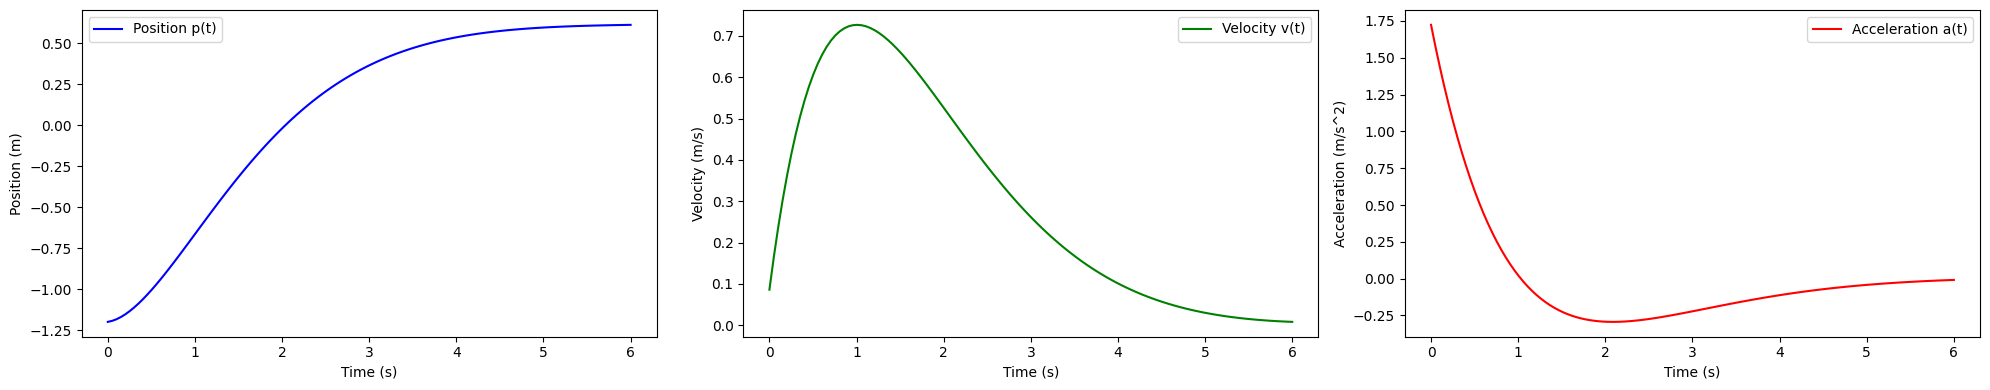

In [5]:

# Define weight matrix in stage and terminal cost
Q_0 = np.diag([1, 1])
R = np.array([[1]])
Qf = Q_0

# Define parameters of simulation
freq = 20 # controll frequency
t_terminal = 6 # time length of simulation



# Instantiate the LQR controller class to initialize iLQR controller
# Arguments: 
#   1) an object of class `Env` (to deliver infos about initial state, constraints, etc.), type: Env  
#   2) an object of class `Dynamics` (to deliver infos about symbolic system dynamics), type: Dynamics  
#   3) weight matrices in cost functions: i) `Q`: weight metrix of state, type: np.array  
#                                         ii) `R`: weight metrix of input, type: np.array  
#   4) freq: control frequency $f$ , type: int  
#   5) name: the name of current coltroller displayed in plots, type: string
controller_lqr = LQRController(env, dynamics, Q_0, R, freq, name='LQR')

# Instantiate the simulator, and then run the simulation
simulator_lqr = Simulator(dynamics, controller_lqr, env, 1/freq, t_terminal)
simulator_lqr.run_simulation()

# Use trajectories getting from LQR to initialize iLQR
_, input_traj_lqr = simulator_lqr.get_trajectories()



# Instantiate the iLQR controller class
# Arguments: 
#   1) an object of class `Env` (to deliver infos about initial state, constraints, etc.), type: Env  
#   2) an object of class `Dynamics` (to deliver infos about symbolic system dynamics), type: Dynamics  
#   3) weight matrices in cost functions: i) `Q`: weight metrix of state in stage cost, type: np.array  
#                                         ii) `R`: weight metrix of input in stage cost, type: np.array  
#                                         iii) `Qf`: weight metrix of state in terminal cost, type: np.array  
#   4) freq: control frequency $f$ , type: int  
#   5) name: the name of current coltroller displayed in plots, type: string
controller_ilqr_0 = iLQRController(env, dynamics, Q_0, R, Qf, freq, name='iLQR_0')

# Initialize iLQR controller with trajectory from LQR, then run setup function to compute optimal policy
controller_ilqr_0.setup(input_traj_lqr)

# Instantiate the simulator, run the simulation, and plot the results
simulator_ilqr_0 = Simulator(dynamics, controller_ilqr_0, env, 1/freq, t_terminal)
simulator_ilqr_0.run_simulation()

# Instantiate the visualizer, and display the plottings and animation
visualizer_ilqr_0 = Visualizer(simulator_ilqr_0)
visualizer_ilqr_0.display_plots()
#visualizer_ilqr_0.display_animation()


---

### **Part (C): LQR v.s. iLQR**

In this chapter, we will explore several aspects of how the iLQR algorithm compares to the LQR algorithm. We will begin by examining the relationship between LQR and iLQR under both linear and nonlinear system dynamics. Then we will delve deeper into the advantages of iLQR especially in the nonlinear case and provide visualizations to enhance understanding.  

#### **1. Relationship between LQR and iLQR**

In this section, we will explore the relationship between LQR and iLQR through a comparative study. We design two test cases:  

 - `xxx_linear`: Using a purely linear system for the dynamics (from case 1 or 2)

 - `xxx_nonlinear`: Using a nonlinear system dynamics (from case 3 or 4)

while keeping the same task definitions and cost design as in the linear case. By analyzing the results, we aim to understand how nonlinearity impacts the effectiveness of the LQR controller under identical conditions. You need to:  

1\) Define the parameters in stage and terminal cost and for simulation;

2\) For the linear case: Specify the case index as 1 or 2, instantiate classes `Env`, `Dynamcis`, `LQRController`, `iLQRController`, `Simulator` and `Visualizer`, and call function `display_contrast_plots()` to see the difference between LQR and iLQR policy; 

3\) For the nonlinear case: Specify the case index as 3 or 4, instantiate classes `Env`, `Dynamcis`, `LQRController`, `iLQRController`, `Simulator` and `Visualizer`, and call function `display_contrast_plots()` to see the difference between LQR and iLQR policy; 


In [6]:
# Define weight matrix in stage and terminal cost
Q_0 = np.diag([1, 1])
R = np.array([[1]])
Qf = Q_0

# Define parameters of simulation
freq = 20 # controll frequency
t_terminal = 6 # time length of simulation


Check passed, Q is a symmetric, positive semi-definite matrix.
Check passed, R is a symmetric, positive definite matrix.
Check passed, current gain K=[[0.95762716 1.68294507]], close-loop system is stable.
LQR Gain Matrix K: [[0.95762716 1.68294507]]
Simulation finished, will start plotting
Check passed, Q is a symmetric, positive semi-definite matrix.
Check passed, R is a symmetric, positive definite matrix.
Use 0 iteration until converge.
Simulation finished, will start plotting


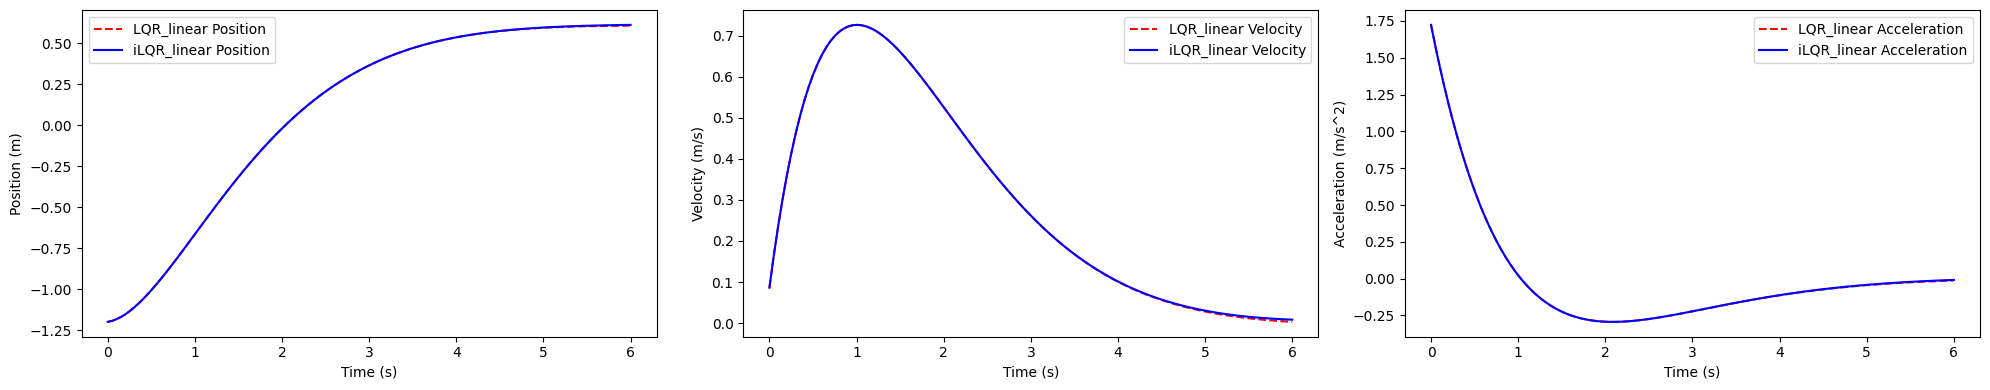

In [7]:
## Linear case
# Define the index for linear case
case_linear = 1 # 1 or 2

# Instantiate class 'Env' and visualize the shape of the slope (left side) and theta curve (right side) 
env_linear = Env(case_linear, np.array([initial_position, initial_velocity]), np.array([target_position, target_velocity]))
#env_linear.test_env()
# Instantiate class 'Dynamics'
dynamics_linear = Dynamics(env_linear)

# Instantiate the LQR controller class to initialize iLQR controller
controller_lqr_linear = LQRController(env_linear, dynamics_linear, Q_0, R, freq, name='LQR_linear')
# Instantiate the simulator, and then run the simulation
simulator_lqr_linear = Simulator(dynamics_linear, controller_lqr_linear, env_linear, 1/freq, t_terminal)
simulator_lqr_linear.run_simulation()
# Use trajectories getting from LQR to initialize iLQR
_, input_traj_lqr_linear = simulator_lqr_linear.get_trajectories()

# Instantiate the iLQR controller class
controller_ilqr_linear = iLQRController(env_linear, dynamics_linear, Q_0, R, Qf, freq, name='iLQR_linear')
# Initialize iLQR controller with trajectory from LQR, then run setup function to compute optimal policy
controller_ilqr_linear.setup(input_traj_lqr_linear)
# Instantiate the simulator, run the simulation, and plot the results
simulator_ilqr_linear = Simulator(dynamics_linear, controller_ilqr_linear, env_linear, 1/freq, t_terminal)
simulator_ilqr_linear.run_simulation()

# Instantiate the visualizer, and display the plottings and animation
visualizer_ilqr_linear = Visualizer(simulator_ilqr_linear)
visualizer_ilqr_linear.display_contrast_plots(simulator_lqr_linear)
#visualizer_ilqr_linear.display_contrast_animation(simulator_lqr_linear)

Check passed, Q is a symmetric, positive semi-definite matrix.
Check passed, R is a symmetric, positive definite matrix.
Check passed, current gain K=[[0.95762716 1.68294507]], close-loop system is stable.
LQR Gain Matrix K: [[0.95762716 1.68294507]]
Simulation finished, will start plotting
Check passed, Q is a symmetric, positive semi-definite matrix.
Check passed, R is a symmetric, positive definite matrix.
Iteration 0: residual error is 0.2451459193727109
Iteration 1: residual error is 0.13429315906183092
Use 2 iteration until converge.
Simulation finished, will start plotting


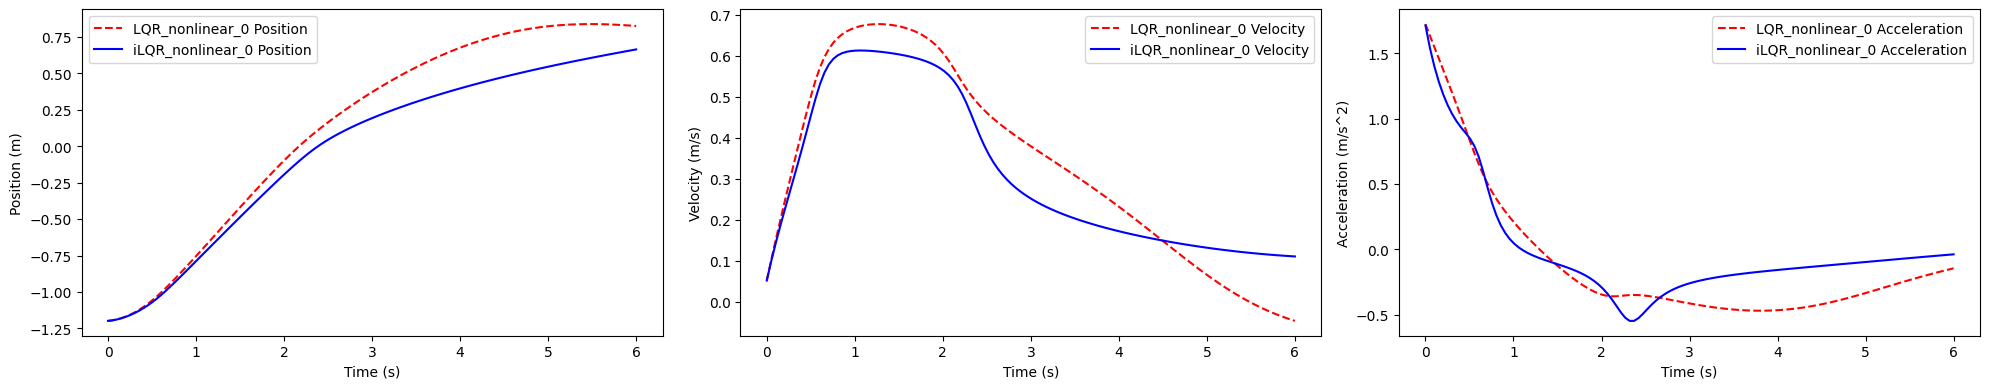

In [8]:
## Nonlinear case
# Define the index for linear case
case_nonlinear_0 = 3 # 3 or 4

# Instantiate class 'Env' and visualize the shape of the slope (left side) and theta curve (right side) 
env_nonlinear_0 = Env(case_nonlinear_0, np.array([initial_position, initial_velocity]), np.array([target_position, target_velocity]))
#env_nonlinear_0.test_env()
# Instantiate class 'Dynamics'
dynamics_nonlinear_0 = Dynamics(env_nonlinear_0)

# Instantiate the LQR controller class to initialize iLQR controller
controller_lqr_nonlinear_0 = LQRController(env_nonlinear_0, dynamics_nonlinear_0, Q_0, R, freq, name='LQR_nonlinear_0')
# Instantiate the simulator, and then run the simulation
simulator_lqr_nonlinear_0 = Simulator(dynamics_nonlinear_0, controller_lqr_nonlinear_0, env_nonlinear_0, 1/freq, t_terminal)
simulator_lqr_nonlinear_0.run_simulation()
# Use trajectories getting from LQR to initialize iLQR
_, input_traj_lqr_nonlinear_0 = simulator_lqr_nonlinear_0.get_trajectories()

# Instantiate the iLQR controller class
controller_ilqr_nonlinear_0 = iLQRController(env_nonlinear_0, dynamics_nonlinear_0, Q_0, R, Qf, freq, name='iLQR_nonlinear_0')
# Initialize iLQR controller with trajectory from LQR, then run setup function to compute optimal policy
controller_ilqr_nonlinear_0.setup(input_traj_lqr_nonlinear_0)
# Instantiate the simulator, run the simulation, and plot the results
simulator_ilqr_nonlinear_0 = Simulator(dynamics_nonlinear_0, controller_ilqr_nonlinear_0, env_nonlinear_0, 1/freq, t_terminal)
simulator_ilqr_nonlinear_0.run_simulation()

# Instantiate the visualizer, and display the plottings and animation
visualizer_ilqr_nonlinear_0 = Visualizer(simulator_ilqr_nonlinear_0)
visualizer_ilqr_nonlinear_0.display_contrast_plots(simulator_lqr_nonlinear_0)
#visualizer_ilqr_nonlinear_0.display_contrast_animation(simulator_lqr_nonlinear_0)

#### **Results Analysis:**

From the results shown in the figure, a significant difference can be observed when applying the LQR control law to a system with nonlinear dynamics versus a linear system:  

- **Linear Dynamics** (`LQR_linear`, `iLQR_linear`): In the linear-quadratic setting, where system dynamics are strictly linear (case 1 or case 2) and the cost function is purely quadratic, iLQR coincides with the LQR solution, leading to the same optimal policy.  

- **Nonlinear Dynamics** (`LQR_nonlinear`, `iLQR_nonlinear`): However, when the system dynamics become nonlinear (case 3 or case 4), iLQR adapts by iteratively approximating both the dynamics and the cost around a nominal trajectory, where LQR can only linearize the system dynamics around a single operating point. From the position curve we can also observe that the LQR curve exhibits tiny overshoot when the iLQR controller can drivce the car gradually approach the target position.

#### **Main Conclusion:**

Compared with the LQR algorithm, this iterative procedure allows for finding a locally optimal policy that is no longer captured by classical LQR. In this sense, iLQR serves as a more general framework, reducing to LQR in the simpler linear-quadratic case but extending to broader classes of nonlinear systems and more complex costs.

---


#### **2. How does iLQR outperform LQR in a nonlinear case**


in terms of optimality: (given nonlinear dynamics)
1) better stablization (without overshoot)
2) lower cost-to-go


-> not changed




#### **1. Relationship between LQR and iLQR**

In this section, we will explore the relationship between LQR and iLQR through a comparative study. We design two test cases:  

 - `xxx_linear`: Using a purely linear system for the dynamics (from case 1 or 2)

 - `xxx_nonlinear`: Using a nonlinear system dynamics (from case 3 or 4)

while keeping the same task definitions and cost design as in the linear case. By analyzing the results, we aim to understand how nonlinearity impacts the effectiveness of the LQR controller under identical conditions. You need to:  

1\) Define the parameters in stage and terminal cost and for simulation;

2\) For the linear case: Specify the case index as 1 or 2, instantiate classes `Env`, `Dynamcis`, `LQRController`, `iLQRController`, `Simulator` and `Visualizer`, and call function `display_contrast_plots()` to see the difference between LQR and iLQR policy; 

3\) For the nonlinear case: Specify the case index as 3 or 4, instantiate classes `Env`, `Dynamcis`, `LQRController`, `iLQRController`, `Simulator` and `Visualizer`, and call function `display_contrast_plots()` to see the difference between LQR and iLQR policy; 

Check passed, Q is a symmetric, positive semi-definite matrix.
Check passed, R is a symmetric, positive definite matrix.
Check passed, current gain K=[[0.95762716 1.68294507]], close-loop system is stable.
LQR Gain Matrix K: [[0.95762716 1.68294507]]
Simulation finished, will start plotting
Check passed, Q is a symmetric, positive semi-definite matrix.
Check passed, R is a symmetric, positive definite matrix.
Iteration 0: residual error is 0.2451459193727109
Iteration 1: residual error is 0.13429315906183092
Use 2 iteration until converge.
Simulation finished, will start plotting


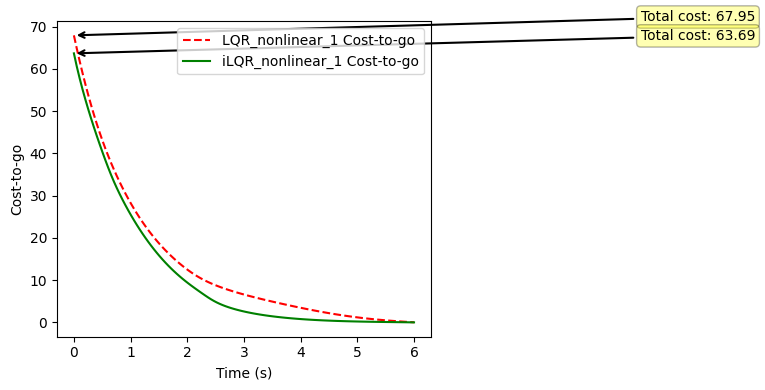

In [9]:
## Nonlinear case
# Define the index for linear case
case_nonlinear_1 = 3 # 3 or 4

# Instantiate class 'Env' and visualize the shape of the slope (left side) and theta curve (right side) 
env_nonlinear_1 = Env(case_nonlinear_1, np.array([initial_position, initial_velocity]), np.array([target_position, target_velocity]))
#env_nonlinear_1.test_env()
# Instantiate class 'Dynamics'
dynamics_nonlinear_1 = Dynamics(env_nonlinear_1)

# Instantiate the LQR controller class to initialize iLQR controller
controller_lqr_nonlinear_1 = LQRController(env_nonlinear_1, dynamics_nonlinear_1, Q_0, R, freq, name='LQR_nonlinear_1')
# Instantiate the simulator, and then run the simulation
simulator_lqr_nonlinear_1 = Simulator(dynamics_nonlinear_1, controller_lqr_nonlinear_1, env_nonlinear_1, 1/freq, t_terminal)
simulator_lqr_nonlinear_1.run_simulation()
# Use trajectories getting from LQR to initialize iLQR
_, input_traj_lqr_nonlinear_1 = simulator_lqr_nonlinear_1.get_trajectories()
# Call rollout function to compute the cost-to-go
cost2go_lqr_nonlinear_1 = simulator_lqr_nonlinear_1.compute_cost2go(Q_0, R, Qf, np.array([target_position, target_velocity]))
#print(f"Cost-to-go of LQR controller: {cost2go_lqr_nonlinear_1[0]}")

# Instantiate the iLQR controller class
controller_ilqr_nonlinear_1 = iLQRController(env_nonlinear_1, dynamics_nonlinear_1, Q_0, R, Qf, freq, name='iLQR_nonlinear_1')
# Initialize iLQR controller with trajectory from LQR, then run setup function to compute optimal policy
controller_ilqr_nonlinear_1.setup(input_traj_lqr_nonlinear_1)
# Instantiate the simulator, run the simulation, and plot the results
simulator_ilqr_nonlinear_1 = Simulator(dynamics_nonlinear_1, controller_ilqr_nonlinear_1, env_nonlinear_1, 1/freq, t_terminal)
simulator_ilqr_nonlinear_1.run_simulation()
# Call rollout function to compute the cost-to-go
cost2go_ilqr_nonlinear_1 = simulator_ilqr_nonlinear_1.compute_cost2go(Q_0, R, Qf, np.array([target_position, target_velocity]))
#print(f"Cost-to-go of iLQR controller: {cost2go_ilqr_nonlinear_1[0]}")

# Instantiate the visualizer, and display the plottings and animation
visualizer_ilqr_nonlinear_1 = Visualizer(simulator_ilqr_nonlinear_1)
visualizer_ilqr_nonlinear_1.display_contrast_cost2go(simulator_lqr_nonlinear_1)

#### **Results Analysis**

From the results, we observe that in the case of nonlinear dynamics, the policy computed by iLQR yields a lower cost-to-go compared to the LQR policy, indicating a more optimal solution. This is because iLQR better accounts for system nonlinearity during the optimization process, rather than relying on a single linearization around a reference point.

----

#### **Wrap-up:**

In this chapter, we introduced the principles of the iLQR controller, provided a simple implementation, and visualized its performance in comparison with the LQR controller. The results demonstrate that iLQR is better suited for handling:

- Nonlinearty in system dynamcis
- Non-quadratic cost function

However, as the cost, iLQR requires greater computational effort and is typically limited to offline computation. Similar to LQR, it also struggles to handle state- and input-constraints. In the following chapters, we introduce the Model Predictive Control (MPC), which approximates an infinite-horizon optimal control problem with a finite and receding horizon formulation. This enables constraint handling and significantly broadens the applicability of optimal control method.